In [9]:
import torch
from torch import nn, optim, autograd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import sys
%matplotlib inline
torch.set_num_threads(1)
torch.manual_seed(1)

In [10]:
print(f"python Version: {sys.version.split(' ')[0]}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

python Version: 3.6.9
torch Version: 1.7.0+cu101
torchvision Version: 0.8.1+cu101
GPU: Tesla P100-PCIE-16GB


In [11]:
@dataclass
class Hyperparameter:
    num_classes: int        = 10
    batchsize: int          = 128
    num_epochs: int         = 15
    latent_size: int        = 32
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
        
hp = Hyperparameter()

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_embedding = nn.Sequential(
            nn.Linear(hp.latent_size, hp.generator_size // 2),
        )
        self.condition_embedding = nn.Sequential(
            nn.Linear(hp.num_classes, hp.generator_size // 2),
        )

        self.noise_mapping = nn.Sequential(
            nn.Linear(hp.generator_size, hp.generator_size),
            nn.ReLU(inplace = True),
            nn.Linear(hp.generator_size, hp.generator_size),
        )

        self.conv1 = nn.ConvTranspose2d(hp.generator_size, hp.generator_size, 4, 1, 0)
        self.bn1 = nn.BatchNorm2d(hp.generator_size)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.ConvTranspose2d(hp.generator_size * 2, hp.generator_size // 2, 3, 2, 1)
        # self.conv2 = nn.ConvTranspose2d(hp.generator_size, hp.generator_size // 2, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(hp.generator_size // 2)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.ConvTranspose2d(hp.generator_size + hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(hp.generator_size // 4)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = nn.ConvTranspose2d(hp.generator_size + hp.generator_size // 4, 1, 4, 2, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, latent, condition):
        vec_latent = self.latent_embedding(latent)
        vec_class = self.condition_embedding(condition)
        mapped_noise = self.noise_mapping(torch.cat([vec_latent, vec_class], dim = 1))
        mapped_noise = mapped_noise.unsqueeze(2).unsqueeze(3)
        combined2 = torch.cat([combined, combined, combined, combined], dim = 2)
        combined2 = torch.cat([combined2, combined2, combined2, combined2], dim = 3)
        x = self.relu1(self.bn1(self.conv1(combined)))
        x = torch.cat([x, combined2], dim = 1)
        x = self.relu2(self.bn2(self.conv2(x)))
        combined3 = torch.cat([combined, combined, combined, combined, combined, combined, combined], dim = 2)
        combined3 = torch.cat([combined3, combined3, combined3, combined3, combined3, combined3, combined3], dim = 3)
        x = torch.cat([x, combined3], dim = 1)
        x = self.relu3(self.bn3(self.conv3(x)))
        combined4 = torch.cat([combined3, combined3], dim = 2)
        combined4 = torch.cat([combined4, combined4], dim = 3)
        x = torch.cat([x, combined4], dim = 1)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [13]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.condition_embedding = nn.Sequential(
            nn.Linear(hp.num_classes, hp.critic_size * 4),
        )
        self.cnn_net = nn.Sequential(
        nn.Conv2d(1, hp.critic_size // 4, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
        nn.InstanceNorm2d(hp.critic_size, affine=True),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Flatten(),
        )
        
        self.Critic_net = nn.Sequential(
        nn.Linear(hp.critic_size * 8, hp.critic_hidden_size),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Linear(hp.critic_hidden_size, 1),
        )
        
    def forward(self, image, condition):
        vec_condition = self.condition_embedding(condition)
        cnn_features = self.cnn_net(image)
        combined = torch.cat([cnn_features.view(128, -1), vec_condition], dim=1)
        return self.Critic_net(combined)

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                                
dataset  = torchvision.datasets.MNIST("mnist", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, num_workers=1,
                                         shuffle=True, drop_last=True, pin_memory=True)

critic, generator = Critic().to("cuda"), Generator().to("cuda")

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4,betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4,betas=(0., 0.9))

In [15]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
all_labels = torch.eye(hp.num_classes, dtype=torch.float32, device="cuda")
fixed_noise = torch.randn((80, hp.latent_size), device="cuda")
fixed_class_labels = all_labels[[i for i in list(range(hp.num_classes)) for idx in range(8)]]
grad_tensor = torch.ones((hp.batchsize, 1), device="cuda")

start_time = time.time()
for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images, real_class_labels = data[0].to("cuda"), all_labels[data[1]].to("cuda")
        
        # Update critic
        critic_optimizer.zero_grad()
        
        critic_output_real = critic(real_images, real_class_labels)
        critic_loss_real = critic_output_real.mean()

        noise = torch.randn((hp.batchsize, hp.latent_size), device="cuda")
        with torch.no_grad(): fake_image = generator(noise, real_class_labels)
        critic_output_fake = critic(fake_image, real_class_labels)
        critic_loss_fake = critic_output_fake.mean()

        alpha = torch.rand((hp.batchsize, 1), device="cuda")
        interpolates = (alpha.view(-1, 1, 1, 1) * real_images + ((1. - alpha.view(-1, 1, 1, 1)) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates, real_class_labels)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()

        critic_loss = -critic_loss_real + critic_loss_fake  + gradient_penalty
        
        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            
            fake_class_labels = all_labels[torch.randint(hp.num_classes, size=[hp.batchsize])]
            noise = torch.randn((hp.batchsize, hp.latent_size), device="cuda")
            fake_image = generator(noise, fake_class_labels)
            critic_output_fake = critic(fake_image, fake_class_labels)
            generator_loss = -critic_output_fake.mean()
            
            generator_loss.backward()
            generator_optimizer.step()
        
        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")
       
        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad(): fake_images = generator(fixed_noise, fixed_class_labels).cpu()
            img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
        iters += 1

[ 0/15][      0][    0.55s]	d_loss/g_loss:  3.1/0.38	
[ 0/15][    100][   36.90s]	d_loss/g_loss: -3.3/-0.22	
[ 0/15][    200][   73.58s]	d_loss/g_loss: -3.2/0.47	
[ 0/15][    300][  110.26s]	d_loss/g_loss: -3.7/ 1.5	
[ 0/15][    400][  146.92s]	d_loss/g_loss: -4.0/ 2.3	
[ 1/15][    468][  172.05s]	d_loss/g_loss: -3.3/0.073	
[ 1/15][    568][  208.77s]	d_loss/g_loss: -2.6/0.65	
[ 1/15][    668][  245.43s]	d_loss/g_loss: -2.2/ 4.2	
[ 1/15][    768][  282.11s]	d_loss/g_loss: -2.5/ 5.7	
[ 1/15][    868][  318.78s]	d_loss/g_loss: -2.0/ 6.6	
[ 2/15][    936][  343.90s]	d_loss/g_loss: -2.1/ 7.6	
[ 2/15][   1036][  380.62s]	d_loss/g_loss: -2.1/ 7.4	
[ 2/15][   1136][  417.28s]	d_loss/g_loss: -2.2/ 7.0	
[ 2/15][   1236][  453.93s]	d_loss/g_loss: -1.8/ 6.5	
[ 2/15][   1336][  490.58s]	d_loss/g_loss: -2.2/1e+01	
[ 3/15][   1404][  515.72s]	d_loss/g_loss: -1.4/ 7.1	
[ 3/15][   1504][  552.45s]	d_loss/g_loss: -2.2/ 8.4	
[ 3/15][   1604][  589.12s]	d_loss/g_loss: -1.9/ 8.0	
[ 3/15][   1704][  625.76

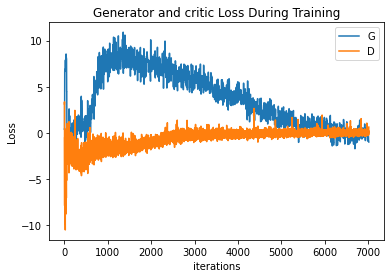

In [16]:
plt.title("Generator and critic Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

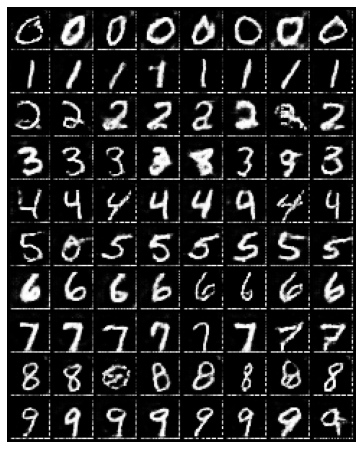

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(10,8))
plt.axis("off")
ims = [[plt.imshow(i.permute(1,2,0), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('im.mp4', writer=writer)

Results:
 - We can see by comparing the loss graphs of the default and noise mapping versions that the gradients for both G and D settle to values close to 0 much faster in the case of the mapping network, although D's gradient suffer from a sudden peak. The gradients in the case of the default version suffer from much higher oscillations and D's loss gets close to 0 much faster than G's loss. This could mean that the mapping network actually helps mapping the initial noise to the set of output classes, so that the following convolutional part of the network could learn the representations of each digit in a much more convergent or stable way.

 - In the case of noise injection the values of the gradients oscillate again. Especially in the case of G, the gradients diverge towards higher values at the beginning of the training. In the end of the loss graph, it can be seen that both D and G's loss have values close to 0.

 - The final output does not seem to vary or improve significantly from one method to another. Each of them apparently creates digits with potential glitches, maybe a few less in the case of the modified versions (noise mapping + injection). Injecting noise between different convolutional layers should allow for better control over the styles. This could be noticed better on datasets with more details, styles and features.